<div style="text-align: center;">
    <h1>Norwegian Artificial Intelligence Research Consortium</h1>
</div>

---

<!-- <img src='photos/norge.png' style='float: left;' width=10% /> -->

<div style="display: flex;">
    <img src='photos/nora.png' style="height: 30%; width: 30%;" />
    <img src='photos/norge.png' style="height: 30%; width: 10%;"  />
</div>

---

<div style="text-align: center;">
    <h1>RoadAI - Reducing emissions in road construction</h1>
</div>

<img src='photos/roadai.png' width=80% />

1.5% of Norwegian CO2 emission comes from construction machines. How can we use data to reduce this emission?

The participants will be provided with data from a road construction site in Viken including GPS data from dump trucks, machine data including daily fuel consumption, and drone maps of the construction site. In addition, we have a small dataset of vibration data from a subset of dumpers, and of course public data such as weather, maps etc.

The challenge is to demonstrate how the data can be exploited for road construction to become more sustainable. Sustainability can be interpreted as directly reduced emission, but also as minimizing construction time and impact on the surroundings. The current status is that many processes are manually controlled, and could benefit from automated decision support: This can for example be obtained through:

* Reduction of idle time
* Optimal flow of dump trucks on the construction site
* Minimization of unnecessary driving
* Optimal driving style with minimal acceleration
* Automated classification of road types for improved planning
* Automated progress reports
* Automated detection of load cycles (when excavators fill the dumpers)

---

### In this notebook, I will deliver my third solution for anomaly detection.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

# Check if TensorFlow is using GPU for operations
print("TensorFlow is using GPU: ", tf.test.is_built_with_cuda())

2023-12-21 17:07:52.286532: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-21 17:07:52.319362: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 17:07:52.319389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 17:07:52.320275: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 17:07:52.325306: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-21 17:07:52.325648: I tensorflow/core/platform/cpu_feature_guard.cc:1

TensorFlow is using GPU:  True


In [3]:
print("CUDA Version:", tf.test.is_built_with_cuda())

CUDA Version: True


In [4]:
sequence_length = 51 # have to be odd because for given sequence, I am predicting its midpoint
frequency = '5S' # length of time step in seconds used to aggregate data

In [5]:
df = pd.read_csv('trips_final_2023-04-26')
df = df.sort_values(by=['TripLogId', 'Timestamp'])

In [6]:
df.head()

,TripLogId,Timestamp,UserAcceleration,RotationRate,Gravity,UserAcceleration_X,UserAcceleration_Y,UserAcceleration_Z,Gravity_X,Gravity_Y,...,AttitudeYaw,Longitude,Latitude,ImputedSpeedInKmHr,MassTypeMaterial,Quantity,features,scaledfeatures,probability,prediction
0,6448b309b35f740000fcd4d3,2023-04-26 05:17:09,0.494810,0.273771,1.000350,0.155324,0.151602,0.444667,0.190991,0.920345,...,2.679457,10.3747,59.952198,0.734713,Stone,40.0,"[0.49481026727047767,0.7347128443671733]","[2.446826267596226,-0.7484202897630048]","[0.0015449437218511026,0.6330577194305421,0.36...",1
1,6448b309b35f740000fcd4d3,2023-04-26 05:17:09,0.494810,0.273771,1.000350,0.155324,0.151602,0.444667,0.190991,0.920345,...,2.679457,10.3747,59.952198,0.734713,Stone,40.0,"[0.49481026727047767,0.7347128443671733]","[2.446826267596226,-0.7484202897630048]","[0.0015449437218511026,0.6330577194305421,0.36...",1
2,6448b309b35f740000fcd4d3,2023-04-26 05:17:10,0.803674,0.965361,1.001966,0.307834,0.468575,0.575820,0.189633,0.928459,...,2.591399,NaN,NaN,0.734713,Stone,40.0,"[0.8036741944134581,0.7347128443671733]","[4.657661416215089,-0.7484202897630048]","[1.7634786802841005e-07,0.9999066588341036,9.3...",1
3,6448b309b35f740000fcd4d3,2023-04-26 05:17:10,0.803674,0.965361,1.001966,0.307834,0.468575,0.575820,0.189633,0.928459,...,2.591399,NaN,NaN,0.734713,Stone,40.0,"[0.8036741944134581,0.7347128443671733]","[4.657661416215089,-0.7484202897630048]","[1.7634786802841005e-07,0.9999066588341036,9.3...",1
4,6448b309b35f740000fcd4d3,2023-04-26 05:17:11,0.704523,1.035574,1.000983,0.178753,0.332786,0.594688,0.184192,0.938393,...,2.421538,NaN,NaN,0.734713,Stone,40.0,"[0.7045229563920764,0.7347128443671733]","[3.947940976944531,-0.7484202897630048]","[8.130568181341908e-06,0.9973522754113213,0.00...",1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195869 entries, 0 to 195868
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   TripLogId           195869 non-null  object 
 1   Timestamp           195869 non-null  object 
 2   UserAcceleration    195869 non-null  float64
 3   RotationRate        195869 non-null  float64
 4   Gravity             195869 non-null  float64
 5   UserAcceleration_X  195869 non-null  float64
 6   UserAcceleration_Y  195869 non-null  float64
 7   UserAcceleration_Z  195869 non-null  float64
 8   Gravity_X           195869 non-null  float64
 9   Gravity_Y           195869 non-null  float64
 10  Gravity_Z           195869 non-null  float64
 11  RotationRate_X      195869 non-null  float64
 12  RotationRate_Y      195869 non-null  float64
 13  RotationRate_Z      195869 non-null  float64
 14  AttitudeRoll        195869 non-null  float64
 15  AttitudePitch       195869 non-nul

In [8]:
df.describe()

,UserAcceleration,RotationRate,Gravity,UserAcceleration_X,UserAcceleration_Y,UserAcceleration_Z,Gravity_X,Gravity_Y,Gravity_Z,RotationRate_X,RotationRate_Y,RotationRate_Z,AttitudeRoll,AttitudePitch,AttitudeYaw,Longitude,Latitude,ImputedSpeedInKmHr,Quantity,prediction
count,195869.000000,195869.000000,195869.000000,195869.000000,195869.000000,195869.000000,195869.000000,195869.000000,195869.000000,195869.000000,195869.000000,195869.000000,195869.000000,195869.000000,195869.000000,53521.000000,53521.000000,195869.000000,193821.000000,195869.000000
mean,0.152977,0.142318,0.997277,0.072610,0.086634,0.086528,-0.385885,0.122326,-0.382240,0.091985,0.063854,0.060616,-0.410564,-0.163369,0.089522,10.350784,59.964689,15.869844,27.641711,1.060137
std,0.139705,0.182995,0.004850,0.076905,0.096181,0.086492,0.596786,0.527772,0.223397,0.144024,0.088645,0.094213,0.969542,0.703396,1.862134,0.023639,0.010413,20.222770,9.178013,0.804116
min,0.000178,0.000718,0.912168,-0.115520,-0.218588,-0.266436,-0.999988,-0.961701,-0.869569,-0.664332,-0.892044,-0.288447,-3.080561,-1.566706,-3.139246,10.319882,59.931909,0.000000,15.000000,0.000000
25%,0.057867,0.043774,0.995898,0.019565,0.026862,0.031182,-0.881074,-0.059058,-0.557553,0.019197,0.019564,0.011999,-1.093692,-0.153396,-1.430207,10.329297,59.955730,0.474356,16.000000,0.000000
50%,0.127289,0.092408,0.999566,0.052915,0.061619,0.067734,-0.788036,0.018254,-0.419594,0.048697,0.044747,0.033389,-0.923245,-0.007588,0.008744,10.342529,59.964861,5.147508,28.000000,1.000000
75%,0.201707,0.185219,1.000000,0.100026,0.117733,0.117095,0.098303,0.160377,-0.303362,0.118909,0.083363,0.080529,0.435844,0.067877,1.585592,10.372737,59.975074,26.602249,30.000000,2.000000
max,4.294458,6.386228,1.089345,2.393915,3.536962,2.564394,0.968552,1.000000,0.436786,6.223258,3.146596,3.289238,3.141541,1.310038,3.141592,10.438213,59.979233,89.157460,40.000000,2.000000


In [9]:
df.TripLogId.unique().shape

(284,)

## Data Preprocessing

In [10]:
X_columns = ['UserAcceleration']

Hour_categories = []
X_categories = []

X_categories.extend(Hour_categories)

In [11]:
df = df.dropna(subset=X_columns)

In [12]:
speed_data = df[['TripLogId', 'ImputedSpeedInKmHr']].to_numpy()
speed_data.shape

(195869, 2)

## Data Preparation

In [13]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def prepare_X_data(df, X_columns, X_categories, sequence_length):
    # Data Preparation
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    
    # Extract hour from timestamp
    df['Hour'] = df['Timestamp'].dt.hour

    # Define the condition (e.g., drop rows before 5 A.M and after 7 P.M)
    operating_hours_condition = (df['Hour'] < 5) | (df['Hour'] > 18)

    df = df[~operating_hours_condition]
    # Sort dataframe by ascending TripLogId and Timestamp
    df = df.sort_values(by=['TripLogId', 'Timestamp'])
    
    # One-hot encoding categorical feature columns
    df = pd.get_dummies(df, columns=['prediction','MassTypeMaterial', 'Hour'], 
                    prefix=['UserAccelerationRegime', 'MassTypeMaterial', 'Hour'])
    
    # Forward-fill missing values in columns 'A' and 'B'
    df[['Longitude', 'Latitude']] = df[['Longitude', 'Latitude']].ffill()

    # Set 'Timestamp' and 'TripLogId' as the index
    df.set_index(['Timestamp', 'TripLogId'], inplace=True)

    # Group by the index and resample to 1-second interval
    df = df.groupby(['TripLogId', pd.Grouper(level='Timestamp', freq=frequency)]).mean()

    # Reset the index
    df.reset_index(inplace=True)
    
    unique_triplogids = df['TripLogId'].unique().tolist()

    # Make sure all categorical feature columns are present, else fill them with zeros
    for category in X_categories:
        if category not in df.columns:
            df[category] = 0
    
    # Select categorical features
    X_categorical_features = df[X_categories]

    # Select other features
    X_features = df[X_columns]
    
    scaler = MinMaxScaler()
    
    tripLogId = df['TripLogId'].to_numpy().reshape(-1, 1)
    
    # Fit and transform the selected features
    X_features_scaled = scaler.fit_transform(X_features)
    
    df_columns = ['TripLogId']
    df_columns.extend(X_columns)

    # Concatenate triplogId with the scaled features
    X_data = np.concatenate((tripLogId, X_features_scaled), axis=1)
    X_data = pd.DataFrame(X_data, columns=df_columns)
    
    X = []

    for triplogid in unique_triplogids:
        filtered_X_data_by_triplogid = X_data[X_data['TripLogId'] == triplogid]
        X_data_narray = filtered_X_data_by_triplogid.drop(columns=['TripLogId']).to_numpy()
        X_data_narray_len = X_data_narray.shape[0]

        for i in range(X_data_narray_len - sequence_length + 1):
            sequence = X_data_narray[i : i + sequence_length]
            X.append(sequence)
    
    X = np.array(X).astype(np.float)
    
    return df, X, scaler

In [14]:
# X, y = prepare_data_for_nn(df, X_columns, X_categories, y_target)

df, X, scaler_X_train = prepare_X_data(df, X_columns, X_categories, sequence_length)

/tmp/ipykernel_13972/1976150927.py:72: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.array(X).astype(np.float)


In [15]:
X.shape

(20874, 51, 1)

In [16]:
from sklearn.model_selection import train_test_split

# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = .3, random_state=42)

# Split temp into validation and test
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=.5, random_state=42)

X_train, X_val = train_test_split(X, test_size = .2, random_state=42)

In [17]:
print(X_train.shape)
print(X_val.shape)

# print(X_test.shape)
# print(y_test.shape)

(16699, 51, 1)
(4175, 51, 1)


## TensorBoard setup

In [18]:
# Import the TensorBoard callback
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Specify the log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [19]:
# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="content/best_checkpoint",
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [20]:
X_train.shape

(16699, 51, 1)

## Deep learning experiment

Anomaly detection

In [21]:
# # Variational autoencoder - the segment works but not presented in the paper, because 
# it is beyond the scope
#
# from keras.models import Model
# from keras.layers import Input, LSTM, RepeatVector, Dense, Lambda, TimeDistributed, Dropout, BatchNormalization
# from keras import regularizers
# from keras import backend as K

# timesteps = X_train.shape[1]
# features = X_train.shape[2]
# batch_size = 32
# epochs = 50
# latent_dim = 4

# inputs = Input(shape=(timesteps, features))

# # Encoder
# L1 = LSTM(128, activation='relu', return_sequences=True,
#          kernel_regularizer=regularizers.l2(0.20))(inputs)
# L2 = LSTM(64, activation='relu', return_sequences=True)(L1)
# L2 = Dropout(0.2)(L2)  # Add dropout here
# L2 = BatchNormalization()(L2)  # Add batch normalization here
# L3 = LSTM(32, activation='relu', return_sequences=True)(L2)

# # Latent space
# L4 = LSTM(8, activation='relu', return_sequences=False)(L3)
# L4 = Dropout(0.2)(L4)  # Add dropout here

# # Sampling from the latent space
# z_mean = Dense(latent_dim)(L4)
# z_log_var = Dense(latent_dim)(L4)

# def sampling(args):
#     z_mean, z_log_var = args
#     batch = K.shape(z_mean)[0]
#     dim = K.int_shape(z_mean)[1]
#     epsilon = K.random_normal(shape=(batch, dim))
#     return z_mean + K.exp(0.5 * z_log_var) * epsilon

# # Use the Lambda layer to include the sampling function in the model
# z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# # Repeat the sampled vector to match the shape of the input
# z_repeated = RepeatVector(timesteps)(z)

# # Decoder
# L5 = LSTM(8, activation='relu', return_sequences=True)(z_repeated)
# L6 = LSTM(16, activation='relu', return_sequences=True)(L5)  # Decoder LSTM with return_sequences=True
# L6 = Dropout(0.2)(L6)  # Add dropout here
# L6 = BatchNormalization()(L6)  # Add batch normalization here
# L7 = LSTM(32, activation='relu', return_sequences=True)(L6)  # Decoder LSTM with return_sequences=True

# # Output layer
# output = TimeDistributed(Dense(features, activation='linear'))(L7)

# # Build the VAE model
# model = Model(inputs, output)

# # Loss function for VAE
# xent_loss = K.mean(K.square(inputs - output))
# kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
# vae_loss = xent_loss + kl_loss

# model.add_loss(vae_loss)

In [22]:
# Plain LSTM autoencoder
from keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense, TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras import regularizers

timesteps = X_train.shape[1]
features = X_train.shape[2]
batch_size = 32
epochs = 20

inputs = Input(shape=(timesteps, features))

# Encoder
L1 = LSTM(32, activation='relu', return_sequences=True,
         kernel_regularizer=regularizers.l2(0.20))(inputs)
L1 = Dropout(0.2)(L1)  # Add dropout here
L1 = BatchNormalization()(L1)  # Add batch normalization here
L2 = LSTM(8, activation='relu', return_sequences=True)(L1)

# Latent space
L3 = LSTM(4, activation='relu', return_sequences=False)(L2)
L3 = Dropout(0.2)(L3)  # Add dropout here

L4 = RepeatVector(timesteps)(L3)

# Decoder
L5 = LSTM(4, activation='relu', return_sequences=True)(L4)
L6 = LSTM(16, activation='relu', return_sequences=True)(L5)  # Decoder LSTM with return_sequences=True
L6 = Dropout(0.2)(L6)  # Add dropout here
L6 = BatchNormalization()(L6)  # Add batch normalization here
L7 = LSTM(32, activation='relu', return_sequences=True)(L6)  # Decoder LSTM with return_sequences=True

# Output layer
output = TimeDistributed(Dense(features, activation='linear'))(L7)  # TimeDistributed for outputting a sequence

model = Model(inputs=inputs, outputs=output)


2023-12-21 17:07:56.671330: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-21 17:07:56.692666: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [23]:
from tensorflow.keras.optimizers import Adam

learning_rate=.0001
momentum = .5

optimizer = Adam(learning_rate=learning_rate, beta_1=momentum)
model.compile(optimizer=optimizer, loss='mse')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 51, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 51, 32)            4352      
                                                                 
 dropout (Dropout)           (None, 51, 32)            0         
                                                                 
 batch_normalization (Batch  (None, 51, 32)            128       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 51, 8)             1312      
                                                                 
 lstm_2 (LSTM)               (None, 4)                 208       
                                                             

In [24]:
# Train the model
history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_val, X_val), 
                    callbacks=[tensorboard_callback, model_checkpoint_callback])

Epoch 1/20
522/522 [==============================] - 34s 53ms/step - loss: 0.3066 - val_loss: 0.2075
Epoch 2/20
522/522 [==============================] - 27s 52ms/step - loss: 0.1440 - val_loss: 0.0933
Epoch 3/20
522/522 [==============================] - 27s 52ms/step - loss: 0.0623 - val_loss: 0.0379
Epoch 4/20
522/522 [==============================] - 27s 51ms/step - loss: 0.0240 - val_loss: 0.0143
Epoch 5/20
522/522 [==============================] - 26s 50ms/step - loss: 0.0083 - val_loss: 0.0046
Epoch 6/20
522/522 [==============================] - 27s 51ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 7/20
522/522 [==============================] - 27s 51ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 8/20
522/522 [==============================] - 26s 51ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/20
522/522 [==============================] - 26s 50ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 10/20
522/522 [==============================] - 27s 51ms/step - loss: 0.001

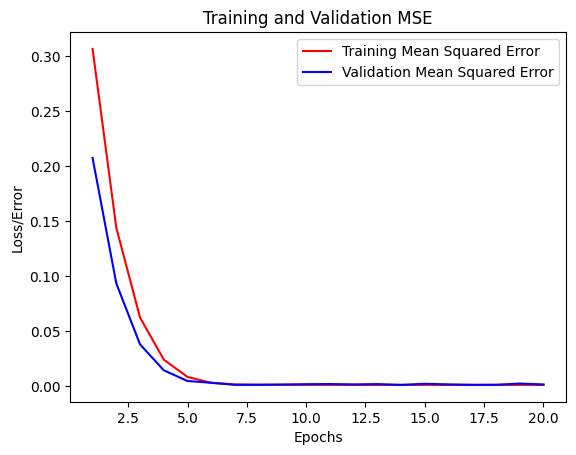

In [25]:
history_dict = history.history

x = range(1, epochs+1)

plt.plot(x, history_dict['loss'], 'r', label='Training Mean Squared Error')
plt.plot(x, history_dict['val_loss'], 'b', label='Validation Mean Squared Error')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Loss/Error')

plt.legend(loc='upper right')
plt.show()

## Evaluate on test dataset

The test dataset is 27th April

In [26]:
df_test = pd.read_csv('trips_final_2023-04-27')

# Forward-fill missing values in columns 'A' and 'B'
df_test[['Longitude', 'Latitude']] = df_test[['Longitude', 'Latitude']].ffill()
df_test = df_test.dropna()

In [27]:
df_test, X_test, scaler = prepare_X_data(df_test, X_columns, X_categories, sequence_length)

/tmp/ipykernel_13972/1976150927.py:72: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X = np.array(X).astype(np.float)


In [28]:
df_test.shape

(25297, 40)

In [29]:
# Get the count of TripLogIds

tripLogCounts = df_test['TripLogId'].value_counts().reset_index().rename(
    columns={'index': 'TripLogId', 'TripLogId': 'Count'})

tripLogCounts = tripLogCounts.sort_values(by='TripLogId', ascending=True)

filteredTripLogIds = tripLogCounts[tripLogCounts['Count'] >= sequence_length]['TripLogId'].to_numpy()

In [30]:
tripLogCounts[tripLogCounts['Count'] >= sequence_length].sort_values(by='Count', ascending=False)

,TripLogId,Count
0,644a34ab6df5b00000816138,795
1,644a0def8b9e270000894ff3,538
2,644a290aaa0a4b00004c7920,429
3,644a86b648de9c00002022ae,421
4,644a17e4b7f4c60000cd90eb,372
...,...,...
187,644a37179c8c8c000073d3b8,53
190,644a99cc7ebe050000b9aa1d,52
192,644a673648a93b000006de79,51
191,644a65a06f161500003f7360,51


In [31]:
filteredTripLogIds.shape

(194,)

In [32]:
sequence_length

51

In [33]:
df_test = df_test[df_test['TripLogId'].isin(filteredTripLogIds)]
df_test = df_test.sort_values(by=['TripLogId', 'Timestamp'])

df_test.shape

(24644, 40)

In [34]:
df_test['TripLogId'].unique().shape

(194,)

In [35]:
df_test.isna().sum()

TripLogId                     0
Timestamp                     0
UserAcceleration              0
RotationRate                  0
Gravity                       0
UserAcceleration_X            0
UserAcceleration_Y            0
UserAcceleration_Z            0
Gravity_X                     0
Gravity_Y                     0
Gravity_Z                     0
RotationRate_X                0
RotationRate_Y                0
RotationRate_Z                0
AttitudeRoll                  0
AttitudePitch                 0
AttitudeYaw                   0
Longitude                     0
Latitude                      0
ImputedSpeedInKmHr            0
Quantity                      0
UserAccelerationRegime_0      0
UserAccelerationRegime_1      0
UserAccelerationRegime_2      0
MassTypeMaterial_Equipment    0
MassTypeMaterial_Soil         0
MassTypeMaterial_Stone        0
Hour_5                        0
Hour_6                        0
Hour_7                        0
Hour_8                        0
Hour_9  

In [36]:
print(df_test.shape)
print(X_test.shape)

(24644, 40)
(14944, 51, 1)


In [37]:
model.load_weights('content/best_checkpoint')

model.evaluate(X_test)

467/467 [==============================] - 7s 14ms/step - loss: 1.3319e-05


1.3318960554897785e-05

In [38]:
# Extracting the predicted values
X_pred = model.predict(X_test)

467/467 [==============================] - 7s 14ms/step


In [39]:
# Inverse transform to get back to the original scale
# X_test = scaler.inverse_transform(X_test)
# X_pred = scaler.inverse_transform(X_pred)

In [40]:
X_pred.shape

(14944, 51, 1)

In [41]:
np.sum(abs(X_pred - X_test)[0,:,:], axis=0)

array([1.71838437])

In [42]:
np.sum(abs(X_pred - X_test), axis=1)

array([[1.71838437],
       [1.70434334],
       [1.71831395],
       ...,
       [4.42153473],
       [4.27798213],
       [4.18336378]])

In [43]:
np.concatenate((X_pred[174,:,:], X_test[174,:,:]), axis=1)

array([[0.04250704, 0.06158005],
       [0.04983434, 0.07702451],
       [0.05105417, 0.05439141],
       [0.04885325, 0.08714356],
       [0.04595141, 0.06239709],
       [0.0434551 , 0.07371619],
       [0.0419057 , 0.08868447],
       [0.04147074, 0.08937013],
       [0.04215782, 0.09435286],
       [0.0437972 , 0.06917673],
       [0.04607327, 0.07345286],
       [0.04888879, 0.07899688],
       [0.05213393, 0.07202396],
       [0.05552407, 0.06691   ],
       [0.058945  , 0.07630142],
       [0.06232072, 0.0874103 ],
       [0.06559436, 0.06893669],
       [0.06874503, 0.0802651 ],
       [0.0716586 , 0.10767817],
       [0.0743286 , 0.08726375],
       [0.07674532, 0.07164206],
       [0.07891597, 0.09526416],
       [0.08085687, 0.09160378],
       [0.08258849, 0.07011686],
       [0.08413254, 0.08648878],
       [0.08551013, 0.06607166],
       [0.08674091, 0.06827926],
       [0.08784261, 0.08342079],
       [0.08883089, 0.09792436],
       [0.0897195 , 0.09218853],
       [0.

In [44]:
scored = pd.DataFrame(index=np.arange(1, X_pred.shape[0] + 1))
scored['Loss_mse'] = np.sum((X_pred - X_test) ** 2, axis=1) / sequence_length
scored['Threshold'] = np.percentile(scored['Loss_mse'], 50) # 90th percentile
scored['Anomaly'] = scored['Loss_mse'] > scored['Threshold']
scored                                              

,Loss_mse,Threshold,Anomaly
1,0.002395,0.001488,True
2,0.002334,0.001488,True
3,0.002360,0.001488,True
4,0.002403,0.001488,True
5,0.002479,0.001488,True
...,...,...,...
14940,0.015694,0.001488,True
14941,0.015006,0.001488,True
14942,0.012873,0.001488,True
14943,0.011911,0.001488,True


/home/user/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.005)

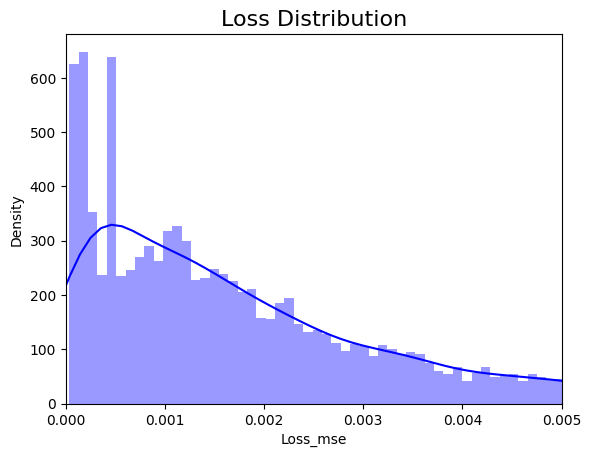

In [45]:
import seaborn as sns

# Categorical featuresplt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mse'], bins=200, kde=True, color='blue')
plt.xlim([0, .005])

In [46]:
tripLogCounts.shape[0]

212

In [47]:
# # not used
#
# def insert_trailing_zeros(df, y_pred, sequence_length):
#     '''
#     Add trailing zeros to y_pred for each triplog_id
#     '''
#     tripLogCounts = df['TripLogId'].value_counts().reset_index()
#     tripLogCounts = tripLogCounts.rename(columns={'index': 'TripLogId', 'TripLogId': 'Count'})
#     num_of_features = y_pred.shape[1]
    
#     # Sort tripLogCounts by TripLogId
#     tripLogCounts = tripLogCounts.sort_values(by='TripLogId', ascending=True)

#     # Reset the index to the default integer-based index
#     tripLogCounts = tripLogCounts.reset_index(drop=True)
    
#     insert_index = 0
    
#      # No row shifting
#     sequence_length -= 1 # predict at same timestep
    
#     # np.zero array to be inserted
#     zero_array = np.zeros((sequence_length, num_of_features))
#     y_pred = np.insert(y_pred, insert_index, zero_array, axis=0)

#     # Iterate through tripLogCounts and insert 10 zeros
#     for index, row in tripLogCounts.iterrows():

#         if index < (tripLogCounts.shape[0] - 1):
#             # Calculate the index where zeros should be deleted
#             insert_index += row['Count']
#             y_pred = np.insert(y_pred, insert_index, zero_array, axis=0)
    
    
#     return y_pred

In [48]:
# not used
#
# def insert_leading_zeros(df, y_pred, sequence_length):
#     '''
#     Add leading zeros to y_pred for each triplog_id
#     '''
#     tripLogCounts = df['TripLogId'].value_counts().reset_index()
#     tripLogCounts = tripLogCounts.rename(columns={'index': 'TripLogId', 'TripLogId': 'Count'})
#     num_of_features = y_pred.shape[1]
    
#     # Sort tripLogCounts by TripLogId
#     tripLogCounts = tripLogCounts.sort_values(by='TripLogId', ascending=True)

#     # Reset the index to the default integer-based index
#     tripLogCounts = tripLogCounts.reset_index(drop=True)
    
#     insert_index = 0
    
#      # No row shifting
#     sequence_length -= 1 # predict at same timestep
    
#     # np.zero array to be inserted
#     zero_array = np.zeros((sequence_length, num_of_features))

#     # Iterate through tripLogCounts and insert 10 zeros
#     for index, row in tripLogCounts.iterrows():

#         if index < (tripLogCounts.shape[0]):
#             # Calculate the index where zeros should be deleted
#             insert_index += (row['Count'] - sequence_length)
#             y_pred = np.insert(y_pred, insert_index, zero_array, axis=0)
#             insert_index += sequence_length
    
#     return y_pred

In [49]:
def insert_leading_and_trailing_zeros(df, y_pred, sequence_length):
    '''
    Add trailing and leading zeros to y_pred for each triplog_id
    '''
    tripLogCounts = df['TripLogId'].value_counts().reset_index()
    tripLogCounts = tripLogCounts.rename(columns={'index': 'TripLogId', 'TripLogId': 'Count'})
    num_of_features = y_pred.shape[1]
    
    # Sort tripLogCounts by TripLogId
    tripLogCounts = tripLogCounts.sort_values(by='TripLogId', ascending=True)

    # Reset the index to the default integer-based index
    tripLogCounts = tripLogCounts.reset_index(drop=True)
    
    insert_index = 0
    
     # No row shifting
    sequence_length -= 1 # predict at the same timestep
    
    # np.zero array to be inserted
    zero_array = np.zeros((sequence_length // 2, num_of_features))
    y_pred = np.insert(y_pred, insert_index, zero_array, axis=0)

    # Iterate through tripLogCounts and insert 10 // 2 zeros
    for index, row in tripLogCounts.iterrows():

        if index < (tripLogCounts.shape[0]) :
            
            insert_index += (row['Count'] - sequence_length // 2)
            y_pred = np.insert(y_pred, insert_index, zero_array, axis=0)
            insert_index += sequence_length // 2
            if insert_index < df.shape[0]:
                y_pred = np.insert(y_pred, insert_index, zero_array, axis=0)
    
    return y_pred

In [50]:
tripLogCounts = df_test['TripLogId'].value_counts().reset_index()
# tripLogCounts = tripLogCounts.rename(columns={'index': 'TripLogId', 'TripLogId': 'Count'})

In [51]:
tripLogCounts.head()

,index,TripLogId
0,644a34ab6df5b00000816138,795
1,644a0def8b9e270000894ff3,538
2,644a290aaa0a4b00004c7920,429
3,644a86b648de9c00002022ae,421
4,644a17e4b7f4c60000cd90eb,372


In [52]:
# scored_final = insert_trailing_zeros(df_test, scored.to_numpy(), sequence_length)
scored_final = insert_leading_and_trailing_zeros(df_test, scored.to_numpy(), sequence_length)

In [53]:
scored_final.shape

(24644, 3)

In [54]:
df_test.shape

(24644, 40)

In [55]:
scored_final

array([[0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0],
       ...,
       [0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0]], dtype=object)

In [56]:
final_columns = list(df_test.columns)
final_columns.extend(['Loss_mse', 'Threshold', 'Anomaly'])

df_test_numpy = df_test.to_numpy()
final = np.concatenate([df_test_numpy, scored_final], axis=1)

final = pd.DataFrame(final, columns=final_columns)

# List of columns to convert to float
float_columns = final.columns[2:]  # Assuming the columns from index 2 onward are to be converted

# Convert selected columns to float
final[float_columns] = final[float_columns].apply(pd.to_numeric, errors='coerce', downcast='float')


In [57]:
# Create a column for abnormal userAcceleration
final['abnormal_UserAcceleration'] = np.where(final['Anomaly'] == 1.0, final['UserAcceleration'], np.nan)

In [58]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24644 entries, 0 to 24643
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   TripLogId                   24644 non-null  object        
 1   Timestamp                   24644 non-null  datetime64[ns]
 2   UserAcceleration            24644 non-null  float32       
 3   RotationRate                24644 non-null  float32       
 4   Gravity                     24644 non-null  float32       
 5   UserAcceleration_X          24644 non-null  float32       
 6   UserAcceleration_Y          24644 non-null  float32       
 7   UserAcceleration_Z          24644 non-null  float32       
 8   Gravity_X                   24644 non-null  float32       
 9   Gravity_Y                   24644 non-null  float32       
 10  Gravity_Z                   24644 non-null  float32       
 11  RotationRate_X              24644 non-null  float32   

In [59]:
final.to_csv('final_check.csv')

In [60]:
final

,TripLogId,Timestamp,UserAcceleration,RotationRate,Gravity,UserAcceleration_X,UserAcceleration_Y,UserAcceleration_Z,Gravity_X,Gravity_Y,...,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Loss_mse,Threshold,Anomaly,abnormal_UserAcceleration
0,644a02c58f0db00000c682e0,2023-04-27 05:06:10,0.268574,0.315316,0.999905,0.154354,0.188648,0.068971,0.737726,-0.024250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,644a02c58f0db00000c682e0,2023-04-27 05:06:15,0.184602,0.273871,0.999909,0.069277,0.071545,0.144513,0.743024,-0.021908,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,644a02c58f0db00000c682e0,2023-04-27 05:06:20,0.168707,0.209576,0.999913,0.061853,0.074797,0.136087,0.733168,-0.024439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,644a02c58f0db00000c682e0,2023-04-27 05:06:25,0.177434,0.171842,0.999849,0.081609,0.101113,0.119520,0.717421,-0.040217,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,644a02c58f0db00000c682e0,2023-04-27 05:06:30,0.197585,0.159555,0.999889,0.103673,0.116455,0.119720,0.708334,-0.017300,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24639,644ab4008fe0870000160317,2023-04-27 17:48:00,0.230132,0.085765,0.999907,0.054962,0.044574,0.215402,-0.998207,0.030736,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
24640,644ab4008fe0870000160317,2023-04-27 17:48:05,0.231545,0.155898,0.999796,0.098076,0.075720,0.192214,-0.998016,0.042057,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
24641,644ab4008fe0870000160317,2023-04-27 17:48:10,0.173862,0.111708,0.999698,0.081000,0.063626,0.120917,-0.998449,0.041403,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
24642,644ab4008fe0870000160317,2023-04-27 17:48:15,0.205118,0.155829,0.999828,0.059324,0.132092,0.143309,-0.998181,0.049769,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN


In [61]:
filteredTripLogIds[::2]

array(['644a02c58f0db00000c682e0', '644a039d0932f4000018f3e0',
       '644a041c75265200006b4683', '644a05f8c5453d00009f3ace',
       '644a068d58025f00000d48ce', '644a08877538240000d154ca',
       '644a09bfcb6c6000007934fa', '644a0a2b1843a400005271d7',
       '644a0b07cff55e00006292c3', '644a0d4b5f95df00006ca40e',
       '644a0ddb88282b0000b4daad', '644a0ed634bdee0000b6aaf5',
       '644a0fbe27a9ea0000cc0273', '644a11533a1c810000538aa7',
       '644a127a243c1600001e1e55', '644a13f78672be0000da39db',
       '644a159064ce450000c22e91', '644a16ea82d46e0000fb7866',
       '644a17e4b7f4c60000cd90eb', '644a1a71a1633400001211d9',
       '644a1bd6a020030000caecf2', '644a1dca15e1c30000c7f03f',
       '644a1e6262cee2000085a955', '644a1f345c015b0000eda80a',
       '644a1fc3d2017c00008d1611', '644a2164ac6e050000d9714c',
       '644a22aa8167c100001e2975', '644a23d2c4c3ac0000bdec59',
       '644a24dc68d83a000088f3d0', '644a266e0a867f0000084b46',
       '644a27fb87893800000ecb81', '644a290aaa0a4b00004

/tmp/ipykernel_13972/935582234.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation=45)


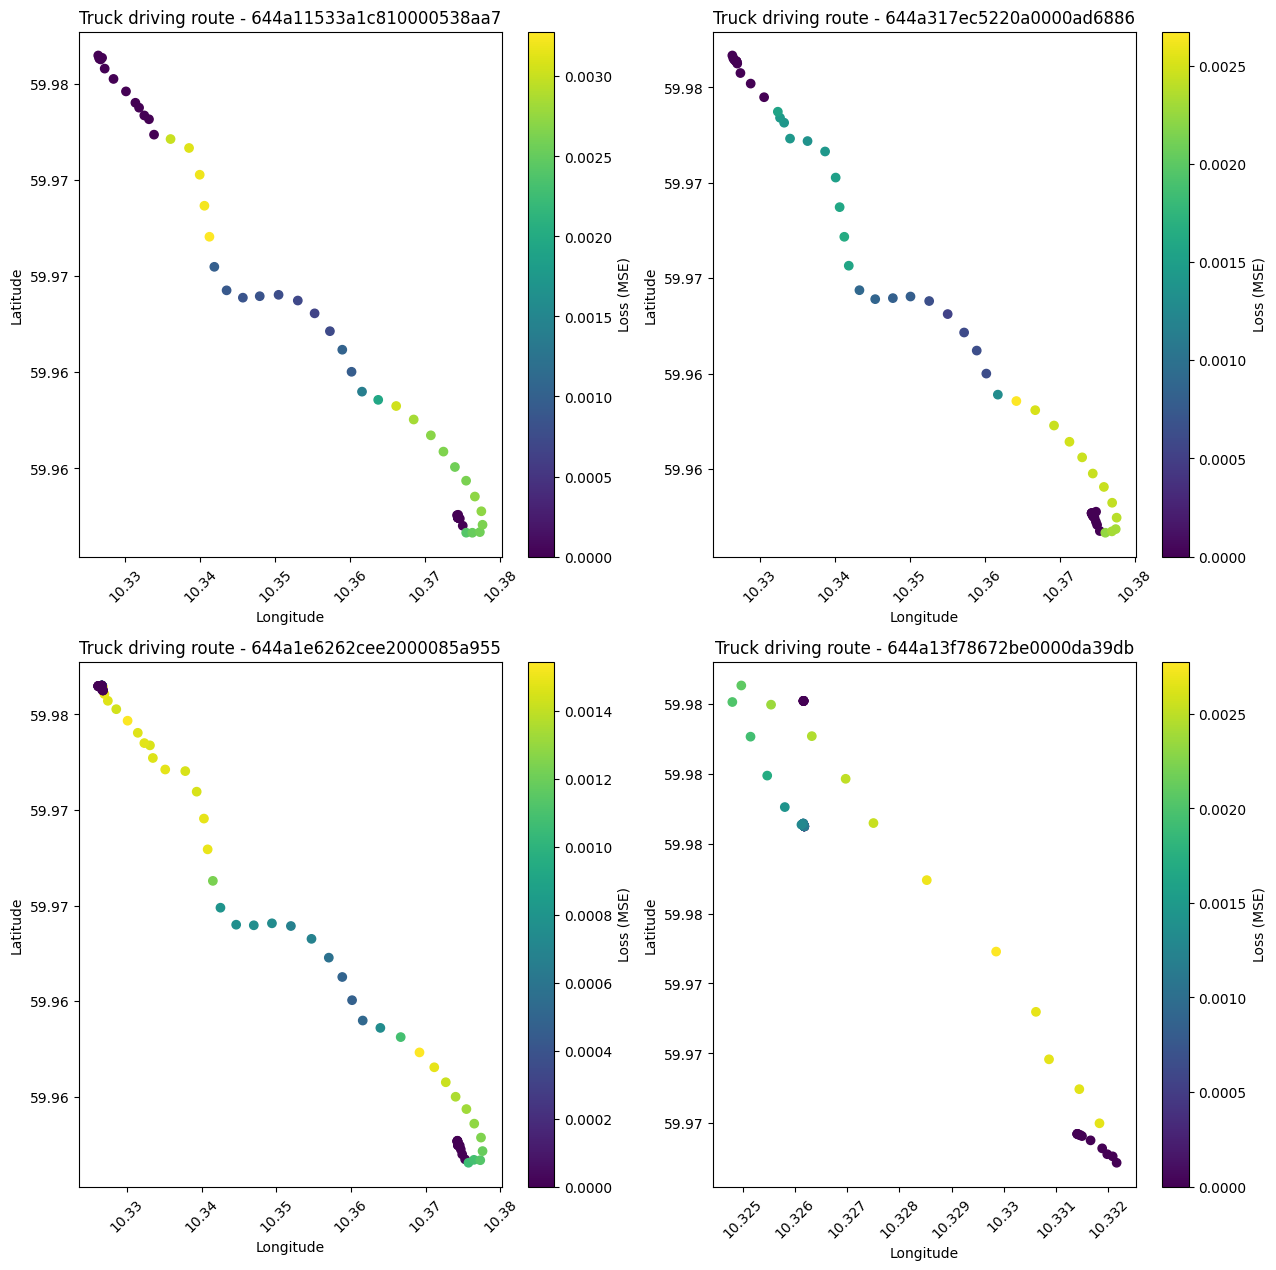

In [62]:
# TRIPLOGID = '644a1e6262cee2000085a955' # no abnormality trip (30 units of stones)
# TRIPLOGID = '644a2ba3e4acc10000448931' # no abnormality trip (30 units of stones)

trips = ['644a11533a1c810000538aa7', '644a317ec5220a0000ad6886', 
         '644a1e6262cee2000085a955','644a13f78672be0000da39db']

# Create a subplot grid with 2 rows and 'num_clusters' columns
fig, axes = plt.subplots(2, len(trips) // 2, figsize=(15, 15))

# Flatten the 2x2 array of axes to iterate over each subplot
axes = axes.flatten()

for plot_id, trip in enumerate(trips):
    final_filtered = final[final['TripLogId'] == trip]

    latitude = final_filtered["Latitude"]
    longitude = final_filtered["Longitude"]
    speed = final_filtered["Loss_mse"]
    
    ax = axes[plot_id]

    # Create a scatter plot
    sc = ax.scatter(longitude[::2], latitude[::2], marker='o', c=speed[::2], cmap='viridis')

    # Customize the y-axis ticks format
    ax.yaxis.set_major_formatter('{:.2f}'.format)  # Set the desired format

    # Rotate x-axis ticks
    ax.set_xticklabels(ax.get_xticks(), rotation=45)

    # Set labels and title
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("Truck driving route - {}".format(trip))  # Use 'trip' instead of undefined 'TRIPLOGID'

    # Add a colorbar
    cbar = plt.colorbar(sc, ax=ax, label="Loss (MSE)")

# Adjust layout to prevent clipping of labels
# plt.tight_layout()

# Show the plot
plt.show()

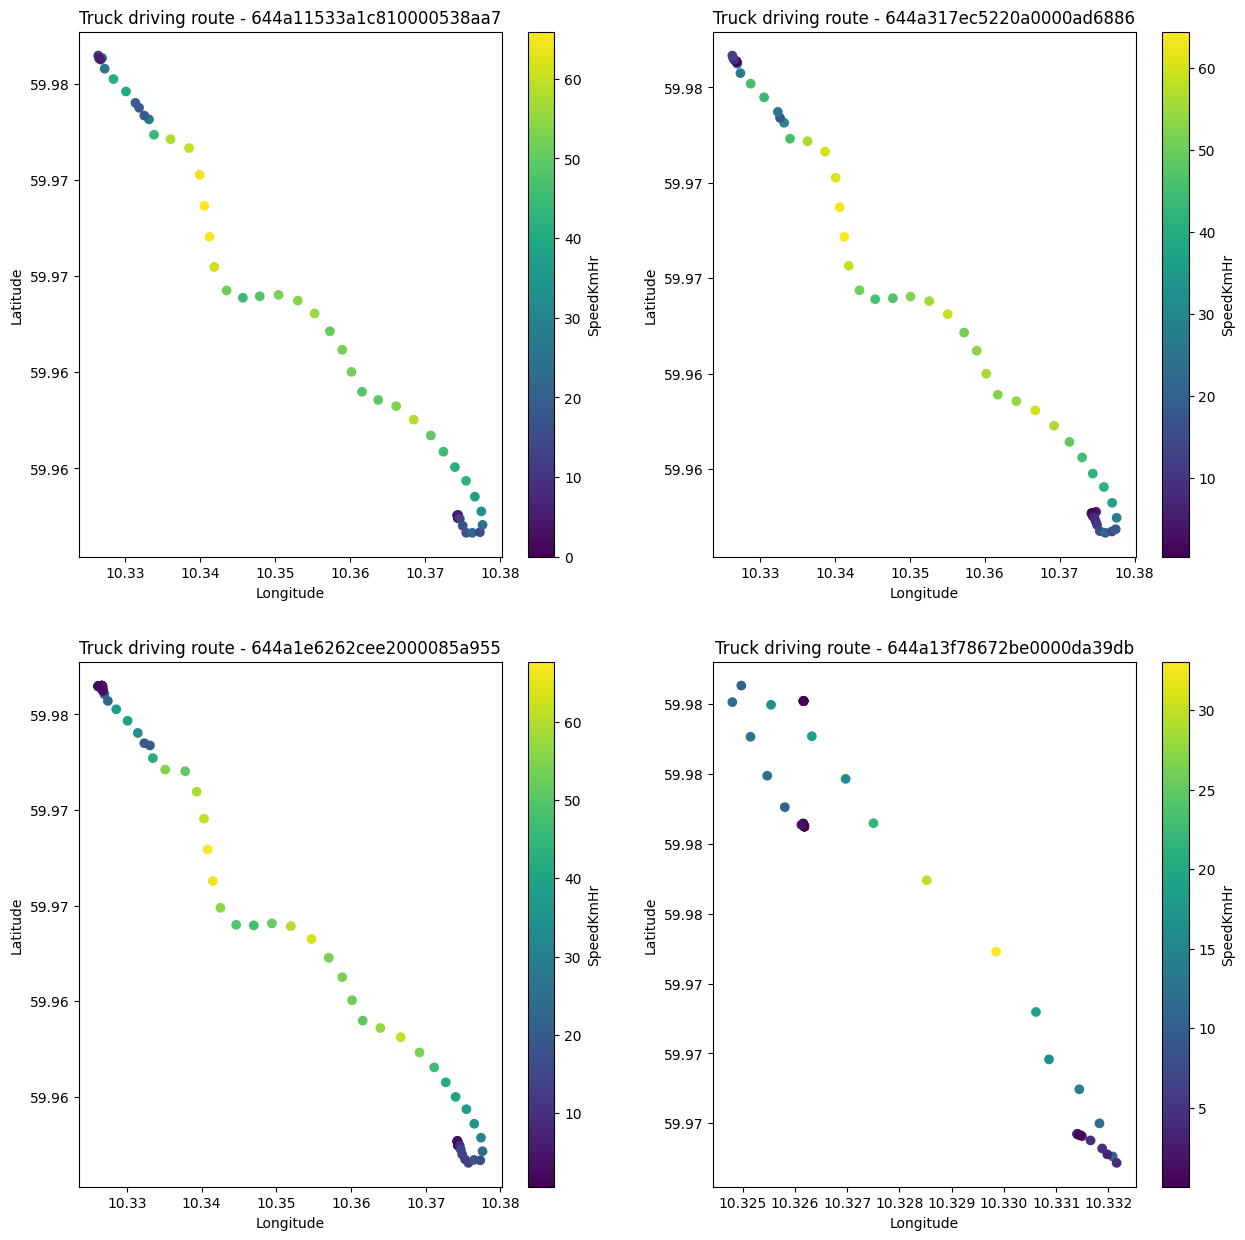

In [64]:
# Create a subplot grid with 2 rows and 'num_clusters' columns
fig, axes = plt.subplots(2, len(trips) // 2, figsize=(15, 15))

# Flatten the 2x2 array of axes to iterate over each subplot
axes = axes.flatten()

for plot_id, trip in enumerate(trips):    
    final_filtered = final[final['TripLogId'] == trip]

    latitude = final_filtered["Latitude"]
    longitude = final_filtered["Longitude"]
    speed = final_filtered["ImputedSpeedInKmHr"]
    
    ax = axes[plot_id]

    # Create a scatter plot
    sc = ax.scatter(longitude[::2], latitude[::2], marker='o', c=speed[::2], cmap='viridis')

    # Customize the y-axis ticks format
    ax.yaxis.set_major_formatter('{:.2f}'.format)  # Set the desired format


    # Set labels and title
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("Truck driving route - {}".format(trip))

    # Add a colorbar
    cbar = plt.colorbar(sc, ax=ax, label="SpeedKmHr")

# Show the plot
plt.show()

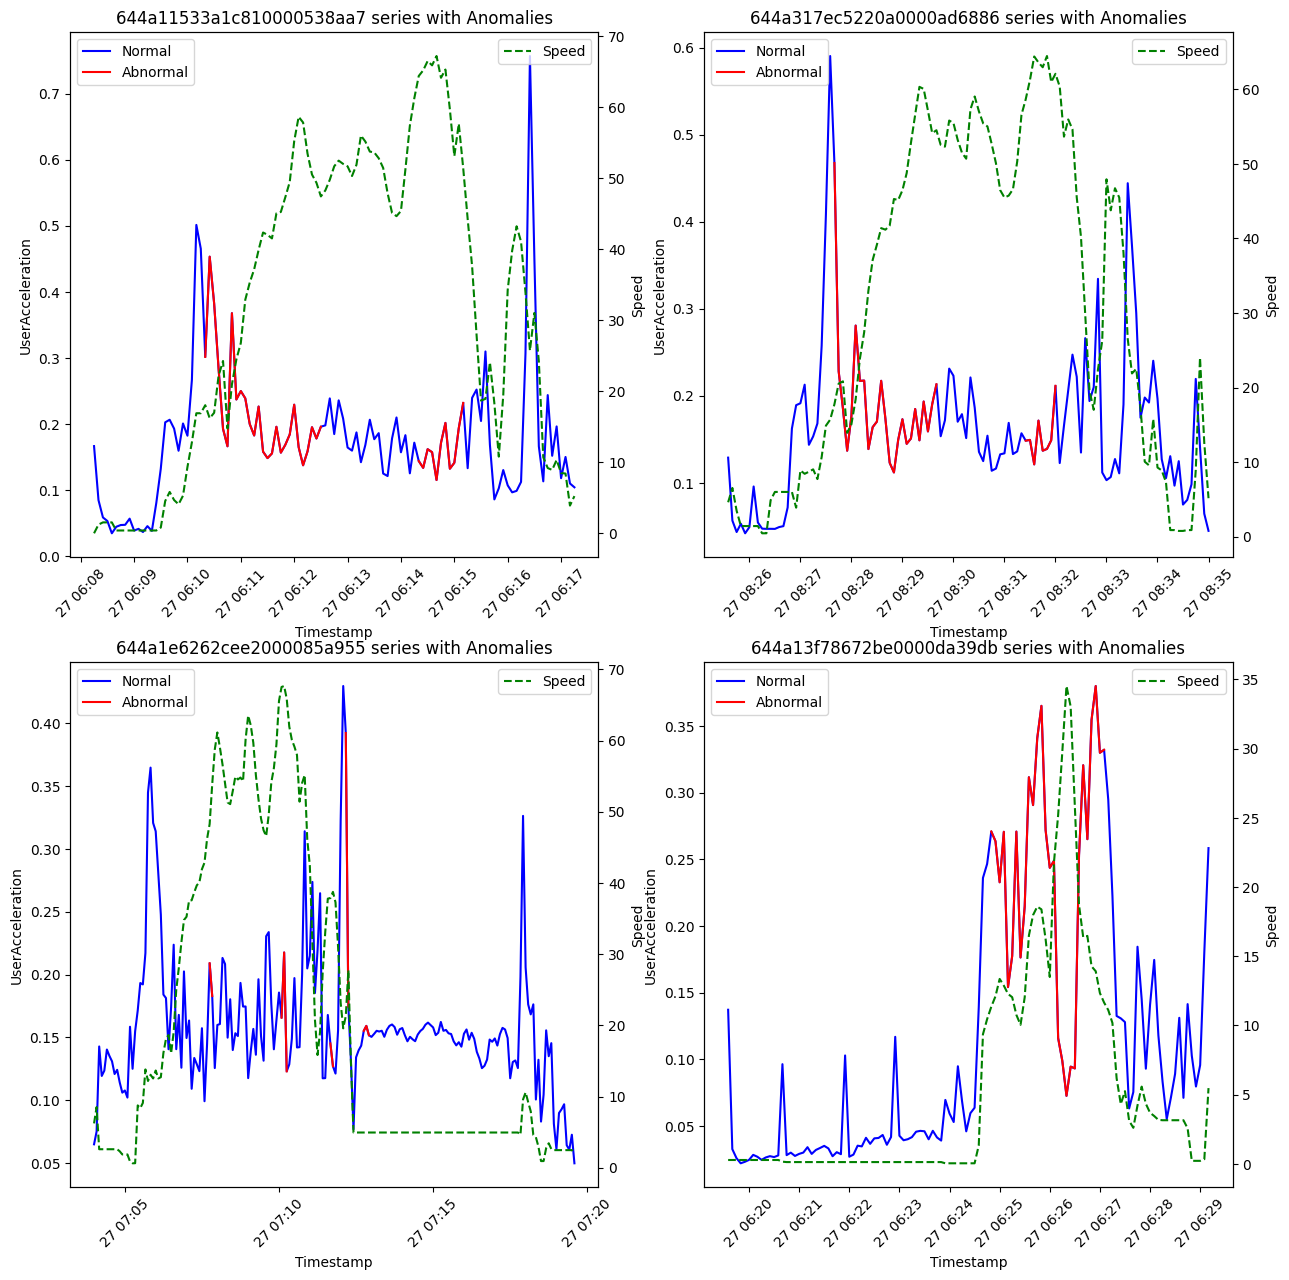

In [65]:
# Create a subplot grid with 2 rows and 'num_clusters' columns
fig, axes = plt.subplots(2, len(trips) // 2, figsize=(15, 15))

# Flatten the 2x2 array of axes to iterate over each subplot
axes = axes.flatten()

for plot_id, trip in enumerate(trips):    
    final_filtered = final[final['TripLogId'] == trip]
    
    ax = axes[plot_id]
    
    ax.plot(final_filtered['Timestamp'], final_filtered['UserAcceleration'], color='blue', label = 'Normal')
    ax.plot(final_filtered['Timestamp'], final_filtered['abnormal_UserAcceleration'], color='red', label = 'Abnormal')

    ax.set_xlabel('Timestamp')
    ax.set_ylabel('UserAcceleration')
    ax.set_title(f'{trip} series with Anomalies')

    # Create a second y-axis for speed
    ax2 = ax.twinx()  # Use 'ax.twinx()' directly
    ax2.plot(final_filtered['Timestamp'], final_filtered['ImputedSpeedInKmHr'], linestyle='--', color='green', label='Speed')

    ax2.legend(loc='upper right')
    ax2.set_ylabel('Speed')  # Use 'ax2.set_ylabel' for the second y-axis

    ax.legend(loc='upper left')  # Use 'ax.legend()' instead of 'ax.set_legend()'

    # Rotate x-axis ticks for each subplot
    ax.tick_params(axis='x', rotation=45)

# Show the plot
plt.show()

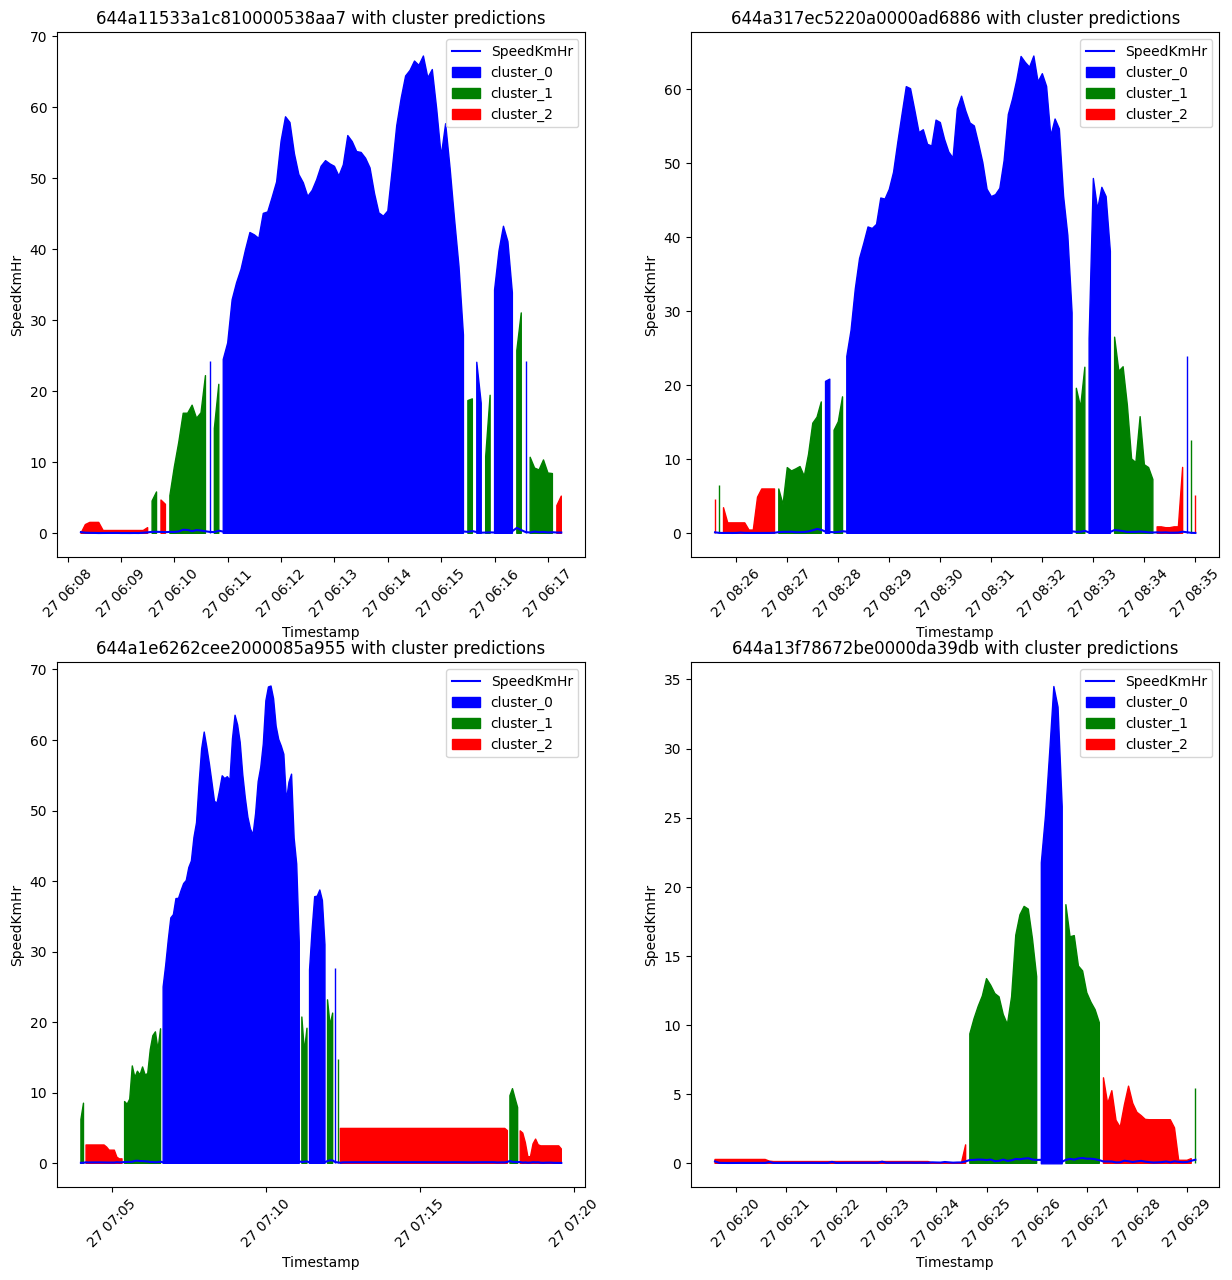

In [66]:
# Create a subplot grid with 2 rows and 'num_clusters' columns
fig, axes = plt.subplots(2, len(trips) // 2, figsize=(15, 15))

# Flatten the 2x2 array of axes to iterate over each subplot
axes = axes.flatten()

for plot_id, trip in enumerate(trips):    
    final_filtered = final[final['TripLogId'] == trip]
    
    ax = axes[plot_id]
    
    # Assuming 'Speed' is the column containing speed data
    ax.plot(final_filtered['Timestamp'], final_filtered['UserAcceleration'], color='blue', label='SpeedKmHr')

    # conditions for clustering
    phase0 = final_filtered['UserAccelerationRegime_0'] > .5  
    phase1 = final_filtered['UserAccelerationRegime_1'] > .5  
    phase2 = final_filtered['UserAccelerationRegime_2'] > .5  

    # Fill clusters based on conditions
    ax.fill_between(final_filtered['Timestamp'], final_filtered['ImputedSpeedInKmHr'], where=phase0, color='blue', label='cluster_0')
    ax.fill_between(final_filtered['Timestamp'], final_filtered['ImputedSpeedInKmHr'], where=phase1, color='green', label='cluster_1')
    ax.fill_between(final_filtered['Timestamp'], final_filtered['ImputedSpeedInKmHr'], where=phase2, color='red', label='cluster_2')

    ax.set_xlabel('Timestamp')
    ax.set_ylabel('SpeedKmHr')
    ax.set_title(f'{trip} with cluster predictions')
    
    # Rotate x-axis ticks for each subplot
    ax.tick_params(axis='x', rotation=45)

    ax.legend(loc='upper right')

In [67]:
final_filtered.to_csv('test.csv')